In [1]:
import sys
import numpy as np
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.datasets import mnist
from random import randint
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
class Discriminator(object):
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100): 
      # latent_size : 이미지를 생성하기 위한 잠재공간, random vector가 저장되어 있음
      # 매번 다른 vector가 생성되기 때문에 조금씩 다른 이미지가 생성됨
        self.CAPACITY = width*height*channels
        self.SHAPE = (width,height,channels)
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)


        self.Discriminator = self.model()  # Discriminator 클래스는 model 을 만든다 
        self.Discriminator.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy'] )
        self.summary()

    def model(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE)) # 784
        model.add(Dense(self.CAPACITY, input_shape=self.SHAPE))  # 784
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(int(self.CAPACITY/2)))  # 392
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))  # 1, 0이면 가짜 1이면 진짜 
        return model

    def summary(self):
        return self.Discriminator.summary()


In [0]:
class Generator(object):
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100):
        self.W = width
        self.H = height
        self.C = channels
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)

        self.LATENT_SPACE_SIZE = latent_size
        self.latent_space = np.random.normal(0,1,(self.LATENT_SPACE_SIZE,))
        
        self.Generator = self.model()
        self.Generator.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
        self.summary()

    def model(self, block_starting_size=128,num_blocks=4):
        model = Sequential()
        
        block_size = block_starting_size 
        model.add(Dense(block_size, input_shape=(self.LATENT_SPACE_SIZE,))) # input 100, conv_fiter=128
        model.add(LeakyReLU(alpha=0.2))  # 128
        model.add(BatchNormalization(momentum=0.8))  # 128

        for i in range(num_blocks-1): # 3번의 block을 돎
            block_size = block_size * 2  # 256, 512, 1024
            model.add(Dense(block_size))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.W * self.H * self.C, activation='tanh'))  # 784
        model.add(Reshape((self.W, self.H, self.C)))  # (28, 28, 1)
        
        return model

    def summary(self):
        return self.Generator.summary()


In [0]:
class GAN(object):
    def __init__(self,discriminator,generator):
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
        
        self.Generator = generator

        self.Discriminator = discriminator
        self.Discriminator.trainable = False
        
        self.gan_model = self.model()
        self.gan_model.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
        self.summary()

    def model(self):
        model = Sequential()
        model.add(self.Generator) # generator에서 생성한 이미지가 바로 discriminator에 들어갈 수 있도록 순서
        model.add(self.Discriminator)
        return model

    def summary(self):
        return self.gan_model.summary()

In [0]:
class Trainer:
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100, epochs =50000, batch=32, checkpoint=50,model_type=-1):# model_type : 모든 종류의 데이터를 다 학습할지 여부
        self.W = width
        self.H = height
        self.C = channels
        self.EPOCHS = epochs
        self.BATCH = batch
        self.CHECKPOINT = checkpoint
        self.model_type=model_type

        self.LATENT_SPACE_SIZE = latent_size

        self.generator = Generator(height=self.H, width=self.W, channels=self.C, latent_size=self.LATENT_SPACE_SIZE)
        self.discriminator = Discriminator(height=self.H, width=self.W, channels=self.C)
        self.gan = GAN(generator=self.generator.Generator, discriminator=self.discriminator.Discriminator)

        self.load_MNIST()

    def load_MNIST(self,model_type=3): # mnist 숫자 중에 3만 사용하겠다, -1은 전부 다 사용
        allowed_types = [-1,0,1,2,3,4,5,6,7,8,9]
        if self.model_type not in allowed_types:
            print('ERROR: Only Integer Values from -1 to 9 are allowed')

        (self.X_train, self.Y_train), (_, _) = mnist.load_data()
        if self.model_type!=-1:
            self.X_train = self.X_train[np.where(self.Y_train==int(self.model_type))[0]] # model type에 맞는 데이터만 가져옴
        
        # Rescale -1 to 1
        # Find Normalize Function from CV Class  
        self.X_train = ( np.float32(self.X_train) - 127.5) / 127.5
        self.X_train = np.expand_dims(self.X_train, axis=3)  # batch 사이즈 추가를 위해 channel을 하나 더 추가해줌
        return

    def train(self):
        for e in range(self.EPOCHS):  # 반복훈련 횟수?
            # Train Discriminator
            # Make the training batch for this model be half real, half noise
            # Grab Real Images for this training batch
            # 실제 이미지와 정답을 준비함
            count_real_images = int(self.BATCH/2)  # 실제 이미지를 절반 가져옴, if batch_size=20, real_image=10
            starting_index = randint(0, (len(self.X_train)-count_real_images))  # real image를 뽑을 인덱스를 랜덤으로 뽑음
            real_images_raw = self.X_train[ starting_index : (starting_index + count_real_images) ]  # real image를 뽑음
            x_real_images = real_images_raw.reshape( count_real_images, self.W, self.H, self.C )  # real image resize, ex) (10, 28, 28, 1)
            y_real_labels = np.ones([count_real_images,1])  # 1로만 구성된 (20(batch size), 1) 배열 -> 정답이기 때문에 1!

            # Grab Generated Images for this training batch
            latent_space_samples = self.sample_latent_space(count_real_images)  # 10장만큼의 latent space 생성
            x_generated_images = self.generator.Generator.predict(latent_space_samples)  # 가상의 이미지를 generator를 통해 생성한다
            y_generated_labels = np.zeros([self.BATCH-count_real_images,1])  # 가상의 이미지에 대한 정답을 만들어줌, 정답은 0!

            # Combine to train on the discriminator
            x_batch = np.concatenate( [x_real_images, x_generated_images] ) # 하나의 batch는 10장의 실제 이미지와 10장의 가상 이미지를 합쳐놓은 것
            y_batch = np.concatenate( [y_real_labels, y_generated_labels] ) # 하나의 batch는 10장의 실제 이미지에 대한 정답과 가상 이미지에 대한 정답을 합쳐놓은 것

            # Now, train the discriminator with this batch
            # train_on_batch : (미리 정한)배치 사이즈만큼의 데이터의 에러를 구하고 역전파를 통해 에러를 줄여주도록 fit해주는 메서드
            discriminator_loss = self.discriminator.Discriminator.train_on_batch(x_batch,y_batch)[0]
        
            # Generate Noise
            x_latent_space_samples = self.sample_latent_space(self.BATCH)  # latent space를 20개를 만듦
            y_generated_labels = np.ones([self.BATCH,1])  # 얼마나 0으로 예측하는지를 보기 위해 1로 채운 배열
            generator_loss = self.gan.gan_model.train_on_batch(x_latent_space_samples,y_generated_labels) 
            
            if e % self.CHECKPOINT == 0 :
              print ('Epoch: '+str(int(e))+', [Discriminator :: Loss: '+str(discriminator_loss)+'], [ Generator :: Loss: '+str(generator_loss)+']')
              self.plot_checkpoint(e)
                        
        return

    def sample_latent_space(self, instances):
        return np.random.normal(0, 1, (instances,self.LATENT_SPACE_SIZE))

    def plot_checkpoint(self,e):
        noise = self.sample_latent_space(16)
        images = self.generator.Generator.predict(noise)
        
        plt.figure(figsize=(4,4))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.H,self.W])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
#         plt.close('all')
        return

In [0]:
# Command Line Argument Method
HEIGHT  = 28
WIDTH   = 28
CHANNEL = 1
LATENT_SPACE_SIZE = 100
EPOCHS = 5000
BATCH = 32
CHECKPOINT = 100  # 100번마다 오차를 보겠다. 
MODEL_TYPE = 0  # 전체 mnist 데이터 중 0만 학습하겠다.

In [8]:
trainer = Trainer(height=HEIGHT,\
                 width=WIDTH,\
                 channels=CHANNEL,\
                 latent_size=LATENT_SPACE_SIZE,\
                 epochs =EPOCHS,\
                 batch=BATCH,\
                 checkpoint=CHECKPOINT,
                 model_type=MODEL_TYPE)
                 








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
____________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



Epoch: 0, [Discriminator :: Loss: 0.73907804], [ Generator :: Loss: 0.78381896]


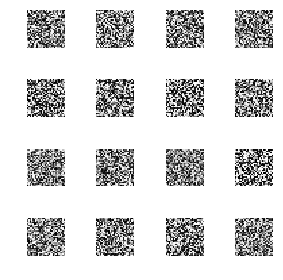

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 100, [Discriminator :: Loss: 0.0077865943], [ Generator :: Loss: 5.0260935]


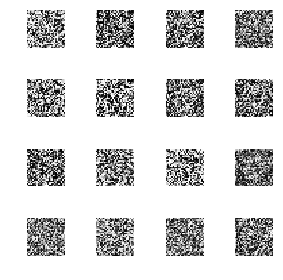

Epoch: 200, [Discriminator :: Loss: 0.12056913], [ Generator :: Loss: 5.5826244]


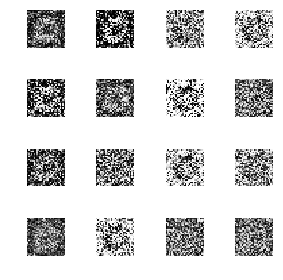

Epoch: 300, [Discriminator :: Loss: 0.13436338], [ Generator :: Loss: 6.4756765]


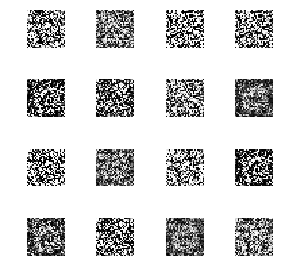

Epoch: 400, [Discriminator :: Loss: 0.0068855076], [ Generator :: Loss: 11.091742]


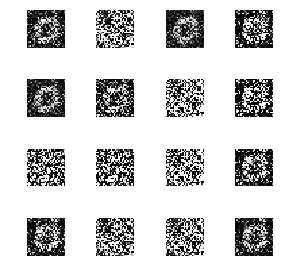

Epoch: 500, [Discriminator :: Loss: 0.03508178], [ Generator :: Loss: 10.618254]


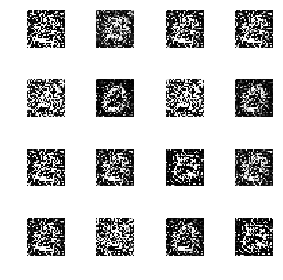

Epoch: 600, [Discriminator :: Loss: 0.013205895], [ Generator :: Loss: 9.818201]


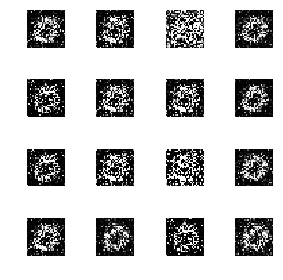

Epoch: 700, [Discriminator :: Loss: 0.17569526], [ Generator :: Loss: 15.286795]


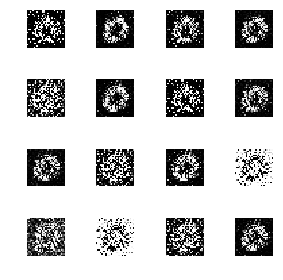

Epoch: 800, [Discriminator :: Loss: 0.031904064], [ Generator :: Loss: 7.616029]


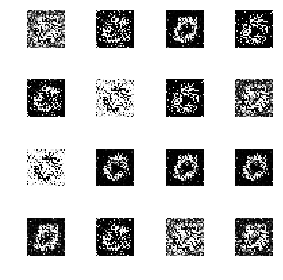

Epoch: 900, [Discriminator :: Loss: 0.029027052], [ Generator :: Loss: 6.809795]


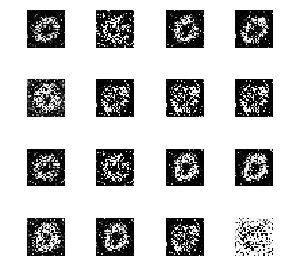

Epoch: 1000, [Discriminator :: Loss: 0.039266583], [ Generator :: Loss: 8.998316]


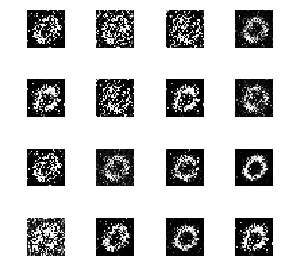

Epoch: 1100, [Discriminator :: Loss: 0.034160435], [ Generator :: Loss: 7.0176234]


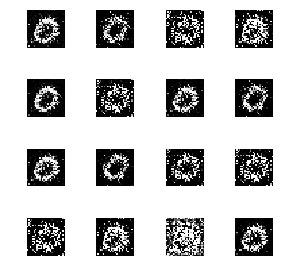

Epoch: 1200, [Discriminator :: Loss: 0.042432137], [ Generator :: Loss: 6.6845036]


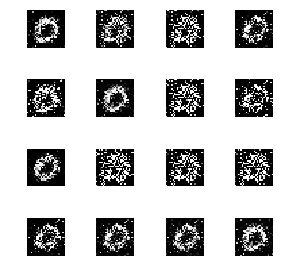

Epoch: 1300, [Discriminator :: Loss: 0.031405598], [ Generator :: Loss: 4.1625786]


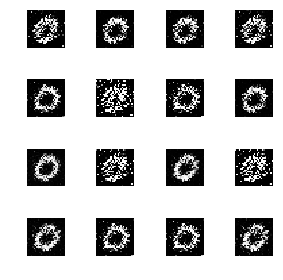

Epoch: 1400, [Discriminator :: Loss: 0.1993112], [ Generator :: Loss: 7.2739244]


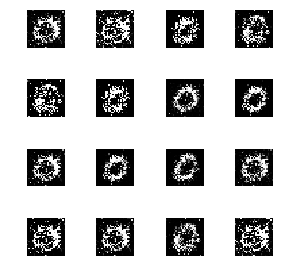

Epoch: 1500, [Discriminator :: Loss: 0.01831667], [ Generator :: Loss: 8.026787]


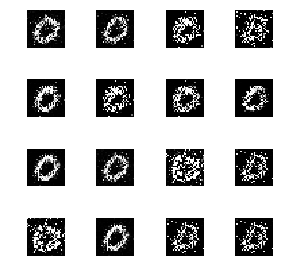

Epoch: 1600, [Discriminator :: Loss: 0.016108833], [ Generator :: Loss: 6.7062135]


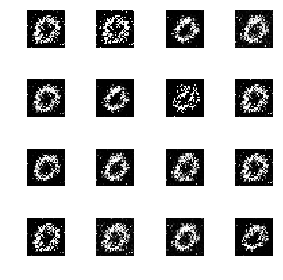

Epoch: 1700, [Discriminator :: Loss: 0.022488153], [ Generator :: Loss: 6.4797683]


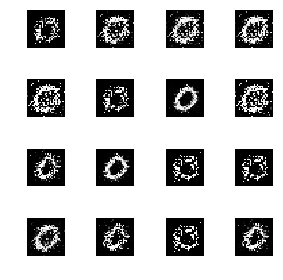

Epoch: 1800, [Discriminator :: Loss: 0.257055], [ Generator :: Loss: 6.407918]


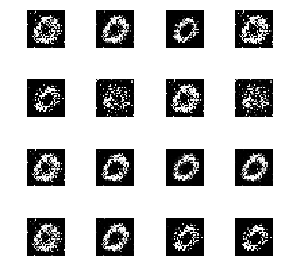

Epoch: 1900, [Discriminator :: Loss: 0.084915124], [ Generator :: Loss: 5.585785]


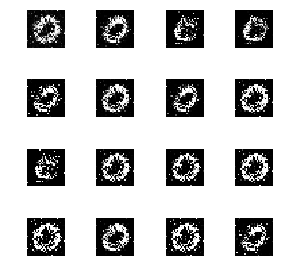

Epoch: 2000, [Discriminator :: Loss: 0.12179282], [ Generator :: Loss: 6.4987354]


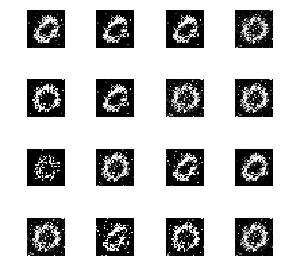

Epoch: 2100, [Discriminator :: Loss: 0.28549746], [ Generator :: Loss: 6.778125]


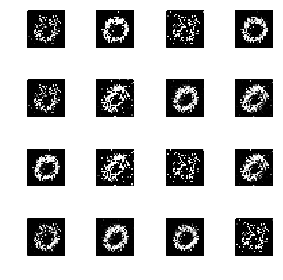

Epoch: 2200, [Discriminator :: Loss: 0.046944916], [ Generator :: Loss: 6.497884]


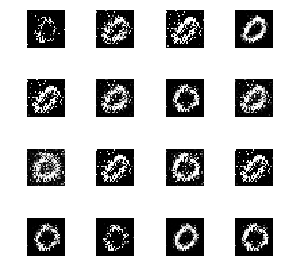

Epoch: 2300, [Discriminator :: Loss: 0.5348535], [ Generator :: Loss: 4.823985]


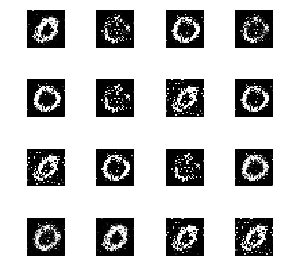

Epoch: 2400, [Discriminator :: Loss: 0.01952549], [ Generator :: Loss: 8.704741]


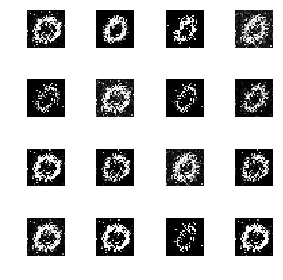

Epoch: 2500, [Discriminator :: Loss: 0.16027294], [ Generator :: Loss: 5.4188223]


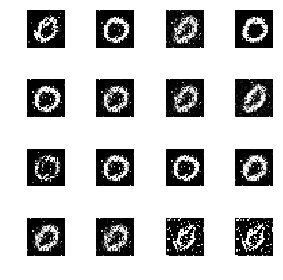

Epoch: 2600, [Discriminator :: Loss: 0.09402709], [ Generator :: Loss: 5.805089]


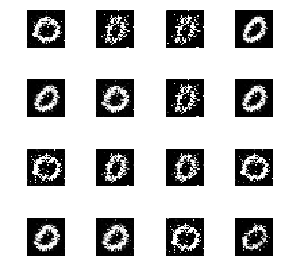

Epoch: 2700, [Discriminator :: Loss: 0.07708198], [ Generator :: Loss: 6.1643047]


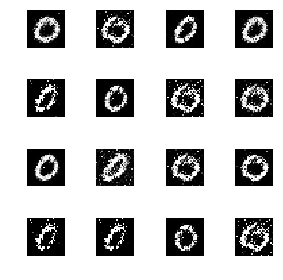

Epoch: 2800, [Discriminator :: Loss: 0.050020307], [ Generator :: Loss: 11.767247]


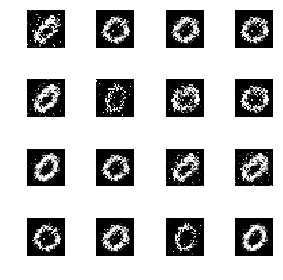

Epoch: 2900, [Discriminator :: Loss: 0.0809897], [ Generator :: Loss: 5.056439]


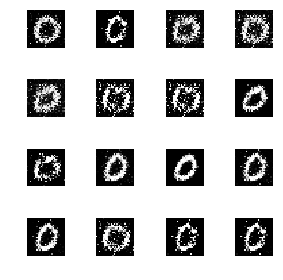

Epoch: 3000, [Discriminator :: Loss: 0.4764091], [ Generator :: Loss: 8.03771]


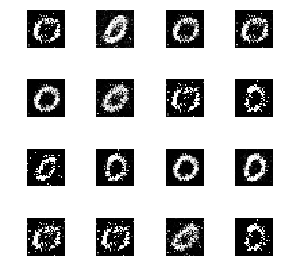

Epoch: 3100, [Discriminator :: Loss: 0.115252584], [ Generator :: Loss: 4.1000614]


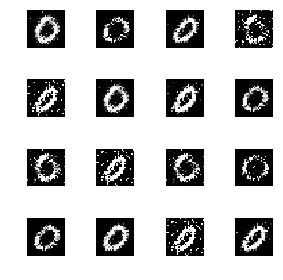

Epoch: 3200, [Discriminator :: Loss: 0.12609768], [ Generator :: Loss: 6.848481]


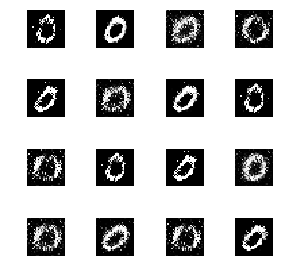

Epoch: 3300, [Discriminator :: Loss: 0.40736866], [ Generator :: Loss: 3.0193305]


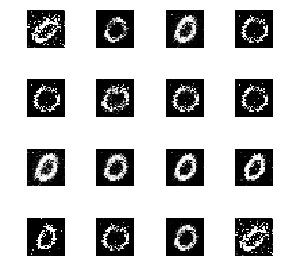

Epoch: 3400, [Discriminator :: Loss: 0.13262448], [ Generator :: Loss: 3.1927085]


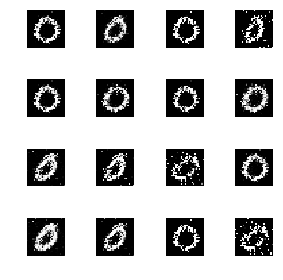

Epoch: 3500, [Discriminator :: Loss: 0.17470802], [ Generator :: Loss: 8.122453]


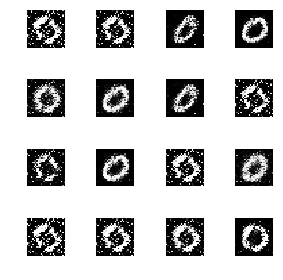

Epoch: 3600, [Discriminator :: Loss: 0.2917152], [ Generator :: Loss: 4.8478823]


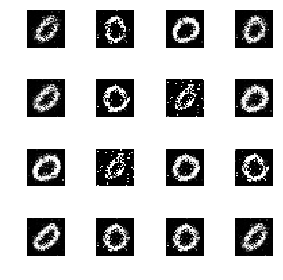

Epoch: 3700, [Discriminator :: Loss: 0.18424442], [ Generator :: Loss: 4.3076234]


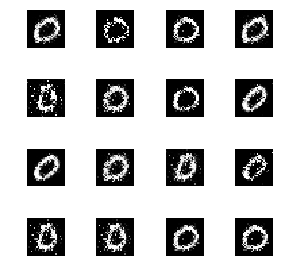

Epoch: 3800, [Discriminator :: Loss: 0.48862708], [ Generator :: Loss: 6.365398]


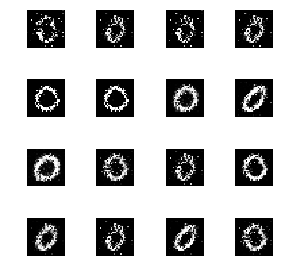

Epoch: 3900, [Discriminator :: Loss: 0.33164132], [ Generator :: Loss: 4.99122]


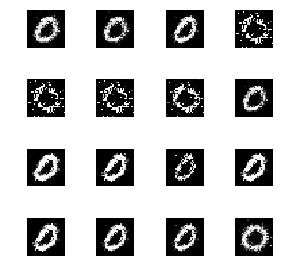

Epoch: 4000, [Discriminator :: Loss: 0.40408412], [ Generator :: Loss: 3.1864374]


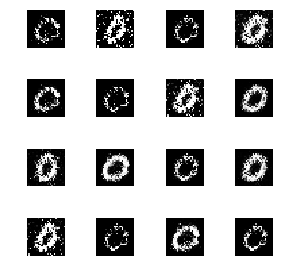

Epoch: 4100, [Discriminator :: Loss: 0.20050366], [ Generator :: Loss: 4.1135745]


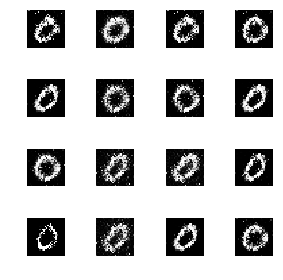

Epoch: 4200, [Discriminator :: Loss: 0.33720672], [ Generator :: Loss: 3.646093]


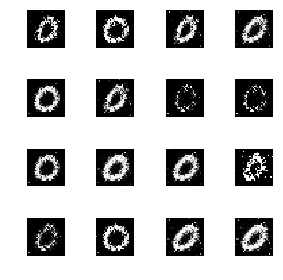

Epoch: 4300, [Discriminator :: Loss: 0.16373593], [ Generator :: Loss: 2.6576443]


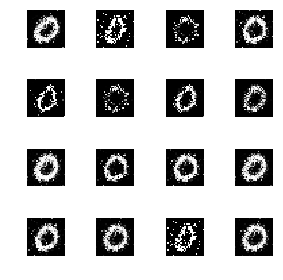

Epoch: 4400, [Discriminator :: Loss: 0.36996394], [ Generator :: Loss: 4.765258]


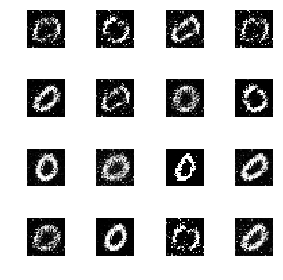

Epoch: 4500, [Discriminator :: Loss: 0.42833972], [ Generator :: Loss: 2.9817526]


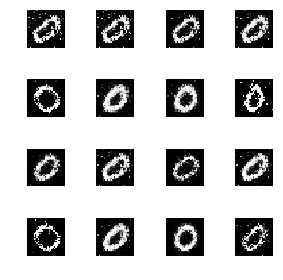

Epoch: 4600, [Discriminator :: Loss: 0.34332004], [ Generator :: Loss: 3.8762121]


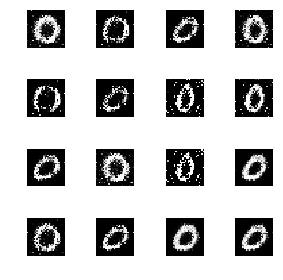

Epoch: 4700, [Discriminator :: Loss: 0.23719229], [ Generator :: Loss: 1.9235746]


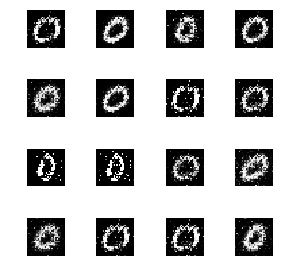

Epoch: 4800, [Discriminator :: Loss: 0.24980557], [ Generator :: Loss: 4.351971]


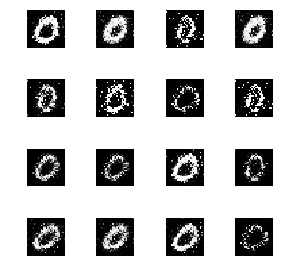

Epoch: 4900, [Discriminator :: Loss: 0.62614787], [ Generator :: Loss: 2.436516]


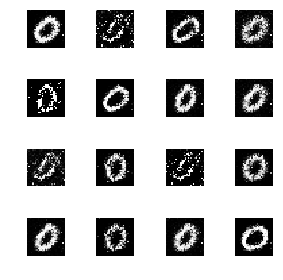

In [9]:
trainer.train()

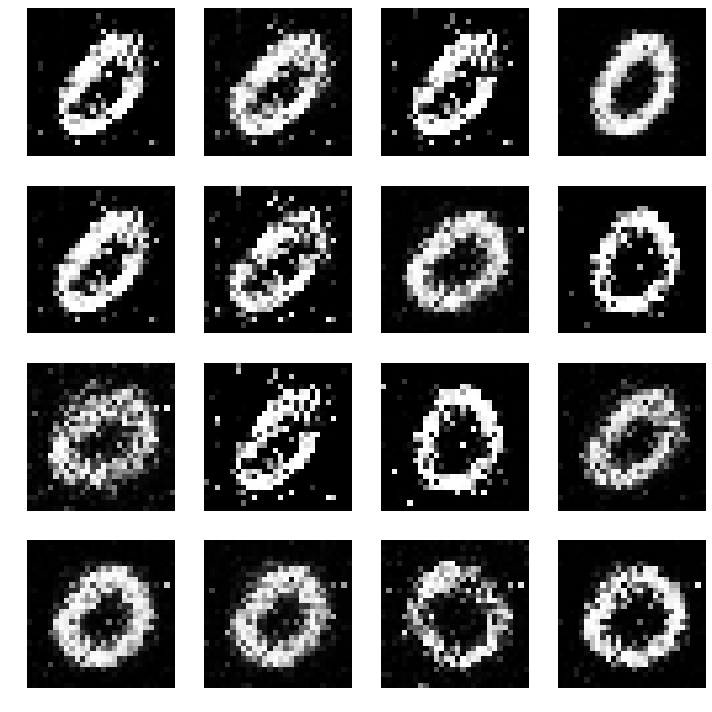

In [10]:
noise = trainer.sample_latent_space(16)
images = trainer.generator.Generator.predict(noise)

plt.figure(figsize=(10,10))
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [28,28])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()
        